In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from lorenz.config import config
from lorenz.datasets import LorenzParallelDataset

from scipy.spatial.distance import pdist

from sklearn.model_selection import train_test_split

from utils.plot import load_model

from utils.dmaps import nystrom, get_hidden_states, create_chunks, dmaps
from utils.dm import diffusion_maps, geometric_harmonics

torch.set_default_dtype(config["TRAINING"]["dtype"])

page_width = 529/72

plt.style.use("paper.mplstyle")

In [2]:
# Load data
np.random.seed(42)

dataset_train = LorenzParallelDataset(
    config["DATA"]["n_train"], config["DATA"]["l_trajectories"], config["DATA"]["parameters"], False
)
dataset_val = LorenzParallelDataset(
    config["DATA"]["n_val"], config["DATA"]["l_trajectories"], config["DATA"]["parameters"], False
)
dataset_test = LorenzParallelDataset(
    config["DATA"]["n_test"], config["DATA"]["l_trajectories_test"], config["DATA"]["parameters"], False
)

Creating data
Creating data
Creating data


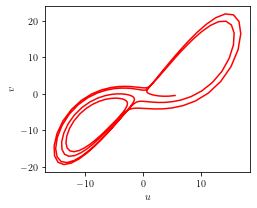

In [3]:
fig = plt.figure(figsize=(page_width/2, 3))
ax = fig.add_subplot(111)
ax.plot(dataset_test.input_data[0], dataset_test.v_data[0][:, 0], "-", color='red')
ax.set_xlabel(r"$u$")
ax.set_ylabel(r"$v$")
plt.tight_layout()
plt.savefig("lorenz/fig/lorenz_trajectory_uv.pdf")
plt.show()

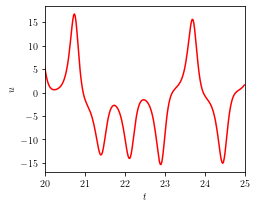

In [4]:
fig = plt.figure(figsize=(page_width/2, 3))
ax = fig.add_subplot(111)
ax.plot(dataset_test.tt[:-1], dataset_test.input_data[0], "-", color="red")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$u$")
ax.set_xlim((20, 25))
plt.tight_layout()
plt.savefig("lorenz/fig/lorenz_trajectory_u.pdf")
plt.show()

In [5]:
# Load model
model = load_model(dataset_train, dataset_val, config)

Using: cpu
Trainable parameters: 2049


/home/felix/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


  0%|          | 0/200 [00:00<?, ?it/s]

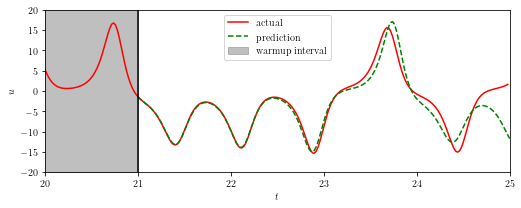

In [6]:
# Create predictions using warmup
idx = 0

start_point = config["DATA"]["max_warmup"]
warmup_length_list = [config["DATA"]["max_warmup"]]
warmup_length = warmup_length_list[0]

initial_condition = torch.tensor(dataset_test.input_data[idx], dtype=torch.get_default_dtype())
trajectory_w_warmup_initial, _ = model.integrate(
    initial_condition[start_point - warmup_length : start_point], len(dataset_test.tt) - start_point - 1
)

fig = plt.figure(figsize=(page_width, 3))
ax = fig.add_subplot(111)
ax.plot(dataset_test.tt[:-1], dataset_test.input_data[idx], "-", label="actual", color="red")
ax.plot(dataset_test.tt[warmup_length:], trajectory_w_warmup_initial[warmup_length:], "--", label="prediction", color="green")
ax.axvline(x=dataset_test.tt[start_point], color="k")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$u$")
ax.set_xlim((20, 25))
ax.set_ylim((-20, 20))
ax.fill_between(x=[20, dataset_test.tt[start_point]], 
                y1=-20, y2=20, color="gray", alpha=0.5, label="warmup interval")
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("lorenz/fig/lorenz_prediction_warmup.pdf")
plt.show()

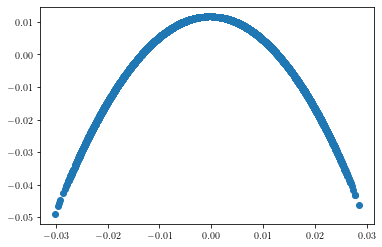

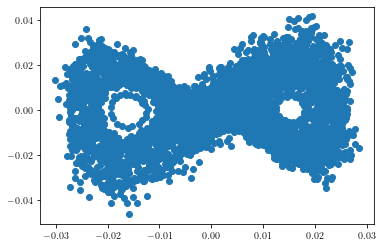

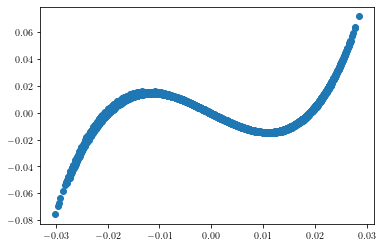

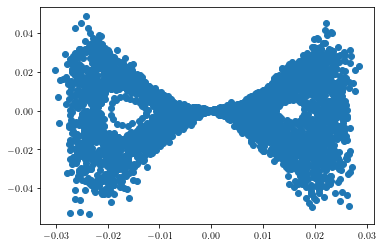

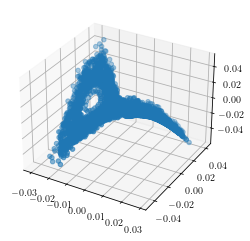

Creating geometric harmonics.
Interpolation function.


In [7]:
# Do geometric harmonics
c_train = get_hidden_states(dataset_train, model)
c_test = get_hidden_states(dataset_test, model)

x_data_train = dataset_train.input_data[:, config["GH"]["initial_set_off"] :]
c_data_train = c_train[:, config["GH"]["initial_set_off"] :]

x_data_test = dataset_test.input_data[:, config["GH"]["initial_set_off"] :]
c_data_test = c_test[:, config["GH"]["initial_set_off"] :]

x_chunks_train = create_chunks(
    x_data_train,
    config["GH"]["max_n_transients"],
    config["GH"]["gh_lenght_chunks"],
    config["GH"]["shift_betw_chunks"],
)
c_chunks_train = create_chunks(
    c_data_train,
    config["GH"]["max_n_transients"],
    config["GH"]["gh_lenght_chunks"],
    config["GH"]["shift_betw_chunks"],
)
c_chunks_train = c_chunks_train[:, 0, :]

x_chunks_test = create_chunks(
    x_data_test,
    config["GH"]["max_n_transients"],
    config["GH"]["gh_lenght_chunks"],
    int(config["GH"]["shift_betw_chunks"]),
)
c_chunks_test = create_chunks(
    c_data_test,
    config["GH"]["max_n_transients"],
    config["GH"]["gh_lenght_chunks"],
    int(config["GH"]["shift_betw_chunks"]),
)
c_chunks_test = c_chunks_test[:, 0, :]

# Diffusion maps on input data
D, V, eps = dmaps(x_chunks_train, eps=10**3, return_eps=True)

for i in range(2, 6):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(V[:, 1], V[:, i])
    ax.set_xlabel('')
    ax.set_ylabel('')
    # plt.savefig('')
    plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(V[:, 1], V[:, 3], V[:, 5])
ax.set_xlabel('')
ax.set_ylabel('')
# plt.savefig('')
plt.show()

V = V[:, [1, 3, 5]]
D = D[[1, 3, 5]]

print("Creating geometric harmonics.")
V_train, V_test, c_chunks_train_train, c_chunks_train_test = train_test_split(
    V, c_chunks_train, random_state=np.random.seed(10), train_size=8 / 10
)

pw = pdist(V_train, "euclidean")
eps_GH = np.median(pw**2) * 0.05

config["GH"]["gh_num_eigenpairs"] = 200
GH = diffusion_maps.SparseDiffusionMaps(
    points=V_train,
    epsilon=eps_GH,
    num_eigenpairs=config["GH"]["gh_num_eigenpairs"],
    cut_off=np.inf,
    renormalization=0,
    normalize_kernel=False,
)
print("Interpolation function.")
interp_c = geometric_harmonics.GeometricHarmonicsInterpolator(
    points=V_train, epsilon=None, values=c_chunks_train_train, diffusion_maps=GH
)


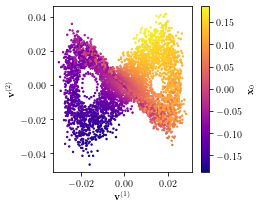

In [8]:
fig = plt.figure(figsize=(page_width/2, 3))
ax = fig.add_subplot(111)
scat = ax.scatter(V[:, 0], V[:, 1], c=c_chunks_train[:, 0], cmap="plasma", s=2)
ax.set_xlabel(r"$\mathbf{v}^{(1)}$")
ax.set_ylabel(r"$\mathbf{v}^{(2)}$")
plt.colorbar(scat, label=r"$\mathbf{x}_0$")
plt.tight_layout()
plt.savefig("lorenz/fig/lorenz_embedding_space.pdf")
plt.show()

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

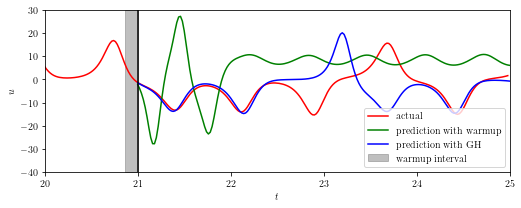

In [9]:
# Create trajectory with informed reservoir initialization
initial_test_chunk = dataset_test.input_data[
    idx, config["DATA"]["max_warmup"] - config["GH"]["gh_lenght_chunks"] : config["DATA"]["max_warmup"]
]

nystrom_test_chunk = nystrom(initial_test_chunk.reshape(1, -1), V, x_chunks_train, D, eps).T

h_pred = interp_c(nystrom_test_chunk)
trajectory_gh, _ = model.integrate(
    torch.tensor(initial_test_chunk[:1], dtype=torch.get_default_dtype()).to(model.device),
    T=len(dataset_test.tt) - config["DATA"]["max_warmup"] + config["GH"]["gh_lenght_chunks"] - 2,
    h0=torch.tensor(h_pred, dtype=torch.get_default_dtype()).to(model.device).unsqueeze(0),
)

trajectory_w_warmup, _ = model.integrate(
    torch.tensor(initial_test_chunk), len(dataset_test.tt) - config["DATA"]["max_warmup"] - 1
)


fig = plt.figure(figsize=(page_width, 3))
ax = fig.add_subplot(111)
ax.plot(dataset_test.tt[:-1], dataset_test.input_data[idx], label="actual", color="red")
# ax.plot(
#     dataset_test.tt[config["DATA"]["max_warmup"] - config["GH"]["gh_lenght_chunks"] :],
#     trajectory_w_warmup,
#     label="prediction with warmup", color="green"
# )
ax.plot(
    dataset_test.tt[config["DATA"]["max_warmup"]:], trajectory_w_warmup[config["GH"]["gh_lenght_chunks"] :],
    label="prediction with warmup", color="green"
)
# ax.plot(
#     dataset_test.tt[config["DATA"]["max_warmup"] - config["GH"]["gh_lenght_chunks"] :],
#     trajectory_gh,
#     label="prediction with GH", color="blue"
# )
ax.plot(
    dataset_test.tt[config["DATA"]["max_warmup"]:], trajectory_gh[config["GH"]["gh_lenght_chunks"]:],
    label="prediction with GH", color="blue"
)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$u$")
ax.set_xlim((20, 25))
ax.set_ylim((-40, 30))
ax.axvline(x=dataset_test.tt[start_point], color="k")
ax.fill_between(x=[dataset_test.tt[start_point-config["GH"]["gh_lenght_chunks"]], dataset_test.tt[start_point]], 
                y1=-40, y2=30, color="gray", alpha=0.5, label="warmup interval")
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("lorenz/fig/lorenz_predictions_gh.pdf")
plt.show()

In [10]:
dataset_train.tt[1]-dataset_train.tt[0]

0.019999999999999574